In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000
test_portion = 0.1
corpus = []

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-11-21 23:35:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.164.176, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   133MB/s    in 1.7s    

2020-11-21 23:35:46 (133 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
num_sentences = 0


with open('/tmp/training_cleaned.csv') as csvfile : 
  reader = csv.reader(csvfile, delimiter = ',')
  for row in reader : 
    list_item = []
    list_item.append(row[5])
    this_label = []
    if this_label == '0' :
      list_item.append(0)
    else : 
      list_item.append(1)

    num_sentences += 1
    corpus.append(list_item)


In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 1]


In [5]:
corpus[1]

["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 1]

In [6]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

In [7]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]

test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [8]:
print(vocab_size)

print(word_index['i'])

138148
1


In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f : 
  for line in f :
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items()  :
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None : 
    embeddings_matrix[i] = embedding_vector


--2020-11-21 23:35:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 172.217.164.176, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   171MB/s    in 1.9s    

2020-11-21 23:36:00 (171 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [10]:
print(len(embeddings_matrix))

138149


In [15]:
model =  tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Conv1D(64, 5, activation='relu'),
                              tf.keras.layers.MaxPooling1D(pool_size=4),
                              tf.keras.layers.LSTM(64),
                              tf.keras.layers.Dense(1, activation='sigmoid') ])

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13814900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,880,053
Trainable params: 65,153
Non-trainable params: 13,814,900
_____________________________________

In [16]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)

testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)


history = model.fit(training_padded, 
                    training_labels,
                    epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels),
                    verbose=2)


print("Training Complete")

Epoch 1/50
4500/4500 - 16s - loss: 0.0010 - accuracy: 0.9998 - val_loss: 1.6678e-06 - val_accuracy: 1.0000
Epoch 2/50
4500/4500 - 16s - loss: 6.5359e-07 - accuracy: 1.0000 - val_loss: 2.0201e-07 - val_accuracy: 1.0000
Epoch 3/50
4500/4500 - 15s - loss: 8.2413e-08 - accuracy: 1.0000 - val_loss: 2.8504e-08 - val_accuracy: 1.0000
Epoch 4/50
4500/4500 - 16s - loss: 2.1096e-08 - accuracy: 1.0000 - val_loss: 1.5444e-08 - val_accuracy: 1.0000
Epoch 5/50
4500/4500 - 16s - loss: 1.0879e-08 - accuracy: 1.0000 - val_loss: 7.6796e-09 - val_accuracy: 1.0000
Epoch 6/50
4500/4500 - 16s - loss: 5.8086e-09 - accuracy: 1.0000 - val_loss: 4.5652e-09 - val_accuracy: 1.0000
Epoch 7/50
4500/4500 - 16s - loss: 3.5349e-09 - accuracy: 1.0000 - val_loss: 2.7650e-09 - val_accuracy: 1.0000
Epoch 8/50
4500/4500 - 15s - loss: 2.6220e-09 - accuracy: 1.0000 - val_loss: 2.6413e-09 - val_accuracy: 1.0000
Epoch 9/50
4500/4500 - 15s - loss: 2.6157e-09 - accuracy: 1.0000 - val_loss: 2.6413e-09 - val_accuracy: 1.0000
Epoch

<Figure size 432x288 with 0 Axes>

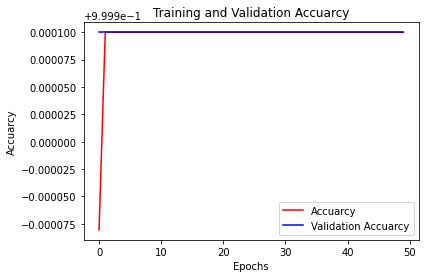

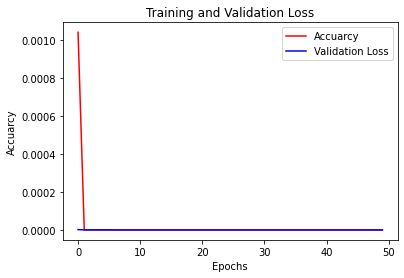

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title("Training and Validation Accuarcy")
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend(["Accuarcy", "Validation Accuarcy"])

plt.figure()


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend(["Accuarcy", "Validation Loss"])

plt.figure()  